<a href="https://colab.research.google.com/github/birddropping/IND5003-Group-Project/blob/main/IND5003_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import xgboost as xgb
#import seaborn as sns
#from functools import reduce

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [ ]:
data_demo = pd.read_csv('data/demographic.csv')
data_diet = pd.read_csv('data/diet.csv')
data_exam = pd.read_csv('data/examination.csv')
data_labs = pd.read_csv('data/labs.csv')
data_meds = pd.read_csv('data/medications.csv', encoding = "ISO-8859-1") # Had to use this encoding standard to read file
data_qns = pd.read_csv('data/questionnaire.csv')
data_dict = pd.read_excel('NHANES 2014 Dictionary.xlsx')

data_vari = pd.read_excel('Variables.xlsx', squeeze = True)

In [ ]:
glu_data = pd.read_sas('data/GLU_H.XPT') # Fasting glucose was not part of the original dataset. Added from NHANES website
vitd_data = pd.read_sas('data/VID_H.XPT')
data_labs = pd.merge(data_labs, glu_data[['SEQN','LBDGLUSI']], how='outer', on=['SEQN'], validate = '1:1')
data_labs = pd.merge(data_labs, vitd_data[['SEQN','LBXVIDMS']], how='outer', on=['SEQN'], validate = '1:1')


In [112]:
#remove duplicates from data_meds as each line covers 1 medication
data_meds_m = data_meds.drop_duplicates(subset = ['SEQN', 'RXDCOUNT'], keep = 'first')

#create a data frame with the illnesses and drugs plus 1 last column whether SEQN is diabetic or not
data_med_2=data_demo.loc[:,['SEQN','RIDAGEYR']]
imax=len(data_demo['SEQN'])
druglist=data_meds['RXDDRUG']
illnesslist=data_meds['RXDRSD1']
med_SEQN=data_meds['SEQN']
SEQN=data_demo['SEQN']

for i in range(0,imax):
    string=''
    lis1=druglist.loc[data_meds['SEQN']==SEQN[i]]
    lis2=illnesslist.loc[data_meds['SEQN']==SEQN[i]].drop_duplicates(keep='first')
    data_med_2.loc[i,['druglist']]=lis1.str.cat(sep=',')
    string=lis2.str.cat(sep=',').upper()
    data_med_2.loc[i,['illness']]=string
    #check whether diabetetic
    if string.find('TYPE 1 DIAB') >= 0:
        data_med_2.loc[i,['DBT']]=1
    elif string.find('TYPE 2 DIAB') >= 0:
        data_med_2.loc[i,['DBT']]=2    
    elif string.find('PREVENT DIAB') >= 0:
        data_med_2.loc[i,['DBT']]=3
    else:
        data_med_2.loc[i,['DBT']]=4


In [113]:
data_med_2

,SEQN,RIDAGEYR,druglist,illness,DBT
0,73557,69,"99999,INSULIN",TYPE 2 DIABETES MELLITUS,2.0
1,73558,54,"GABAPENTIN,INSULIN GLARGINE,OLMESARTAN,SIMVAST...","RESTLESS LEGS SYNDROME,TYPE 2 DIABETES MELLITU...",2.0
2,73559,72,"INSULIN ASPART,INSULIN GLARGINE,PANCRELIPASE,S...","TYPE 2 DIABETES MELLITUS,DISEASE OF PANCREAS, ...",2.0
3,73560,9,,,4.0
4,73561,73,"55555,CARVEDILOL,LEVOTHYROXINE,VALSARTAN","ESSENTIAL (PRIMARY) HYPERTENSION,HYPOTHYROIDIS...",4.0
...,...,...,...,...,...
10170,83727,26,,,4.0
10171,83728,2,,,4.0
10172,83729,42,,,4.0
10173,83730,7,,,4.0


Combine the 6 datasets together as 1 with SEQN as the lead. From there, we can trim out the variables that is not needed for our application of diabetes and mental health.

In [114]:
# Create massive dataset
dataset = pd.merge(data_demo, data_diet, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_exam, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_labs, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_meds_m, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_qns, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset = pd.merge(dataset, data_med_2, how = 'outer', on = ['SEQN'], validate = "1:1")
dataset


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR_x,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGE,DMDHRBR4,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,BPXML1,BPXSY1,BPXDI1,BPAEN1,BPXSY2,BPXDI2,BPAEN2,BPXSY3,BPXDI3,BPAEN3,BPXSY4,BPXDI4,BPAEN4,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,BMXBMI,BMDBMIC,BMXLEG,BMILEG,BMXARML,...,PAQ759D,PAQ759E,PAQ759F,PAQ759G,PAQ759H,PAQ759I,PAQ759J,PAQ759K,PAQ759L,PAQ759M,PAQ759N,PAQ759O,PAQ759P,PAQ759Q,PAQ759R,PAQ759S,PAQ759T,PAQ759U,PAQ759V,PAQ762,PAQ764,PAQ766,PAQ679,PAQ750,PAQ770,PAQ772A,PAQ772B,PAQ772C,PAAQUEX,PUQ100,PUQ110,RHQ010,RHQ020,RHQ031,RHD043,RHQ060,RHQ070,RHQ074,RHQ076,RHQ078,RHQ131,RHD143,RHQ160,RHQ162,RHQ163,RHQ166,RHQ169,RHQ172,RHD173,RHQ171,RHD180,RHD190,RHQ197,RHQ200,RHD280,RHQ291,RHQ305,RHQ332,RHQ420,RHQ540,RHQ542A,RHQ542B,RHQ542C,RHQ542D,RHQ554,RHQ560Q,RHQ560U,RHQ570,RHQ576Q,RHQ576U,RHQ580,RHQ586Q,RHQ586U,RHQ596,RHQ602Q,RHQ602U,RXQ510,RXQ515,RXQ520,RXQ525G,RXQ525Q,RXQ525U,RXD530,SLD010H,SLQ050,SLQ060,SMQ020,SMD030,SMQ040,SMQ050Q,SMQ050U,SMD055,SMD057,SMQ078,SMD641,SMD650,SMD093,SMDUPCA,SMD100BR,SMD100FL,SMD100MN,SMD100LN,SMD100TR,SMD100NI,SMD100CO,SMQ621,SMD630,SMQ661,SMQ665A,SMQ665B,SMQ665C,SMQ665D,SMQ670,SMQ848,SMQ852Q,SMQ852U,SMAQUEX2,SMD460,SMD470,SMD480,SMQ856,SMQ858,SMQ860,SMQ862,SMQ866,SMQ868,SMQ870,SMQ872,SMQ874,SMQ876,SMQ878,SMQ880,SMAQUEX.x,SMQ681,SMQ690A,SMQ710,SMQ720,SMQ725,SMQ690B,SMQ740,SMQ690C,SMQ770,SMQ690G,SMQ845,SMQ690H,SMQ849,SMQ851,SMQ690D,SMQ800,SMQ690E,SMQ817,SMQ690I,SMQ857,SMQ690J,SMQ861,SMQ863,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX.y,SXD021,SXQ800,SXQ803,SXQ806,SXQ809,SXQ700,SXQ703,SXQ706,SXQ709,SXD031,SXD171,SXD510,SXQ824,SXQ827,SXD633,SXQ636,SXQ639,SXD642,SXQ410,SXQ550,SXQ836,SXQ841,SXQ853,SXD621,SXQ624,SXQ627,SXD630,SXQ645,SXQ648,SXQ610,SXQ251,SXQ590,SXQ600,SXD101,SXD450,SXQ724,SXQ727,SXQ130,SXQ490,SXQ741,SXQ753,SXQ260,SXQ265,SXQ267,SXQ270,SXQ272,SXQ280,SXQ292,SXQ294,WHD010,WHD020,WHQ030,WHQ040,WHD050,WHQ060,WHQ070,WHD080A,WHD080B,WHD080C,WHD080D,WHD080E,WHD080F,WHD080G,WHD080H,WHD080I,WHD080J,WHD080K,WHD080M,WHD080N,WHD080O,WHD080P,WHD080Q,WHD080R,WHD080S,WHD080T,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520,RIDAGEYR_y,druglist,illness,DBT
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,1.0,1.0,

In [120]:
# Create list of variables of interest
col_list = data_vari.tolist()

# Creating dataframe with variables of interest
final_data = dataset[col_list]

# Subsetting based on glycohaemoglobin levels
final_data = final_data.dropna(subset=['LBXGH']) 
final_data

KeyError: "['RIDAGEYR', 'LBDGLUSI', 'LBXVIDMS'] not in index"

As shown in previous cell, all datasets have been combined and only features related to diabetes and mental health have been filtered out to create the dataset from which analysis will be done.

In [122]:
SES = ['INDHHIN2', 'INDFMIN2', 'FSD151', 'FSQ165']
SES_data = final_data[SES]
SES_data

,INDHHIN2,INDFMIN2,FSD151,FSQ165
0,1.0,1.0,2.0,1.0
1,1.0,1.0,2.0,1.0
2,1.0,1.0,2.0,2.0
4,1.0,1.0,2.0,2.0
5,1.0,1.0,2.0,2.0
...,...,...,...,...
10164,1.0,1.0,2.0,2.0
10166,1.0,1.0,2.0,1.0
10167,1.0,1.0,2.0,2.0
10170,1.0,1.0,2.0,2.0


In [83]:
SES_data.describe()

,INDHHIN2,INDFMIN2,FSD151,FSQ165
count,6643.000000,6643.000000,6643.000000,6643.000000
mean,2.250188,2.198404,1.894174,1.680265
std,0.968503,0.973180,0.307638,0.466409
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000
75%,3.000000,3.000000,2.000000,2.000000
max,4.000000,4.000000,2.000000,2.000000


Coded results for household/family income

|Value|Salary Range|
|-----|------------|
|1|0 to 4999|
|2|5000 to 9999|
|3|10000 to 14999|
|4|15000 to 19999|
|5|20000 to 24999|
|6|25000 to 34999|
|7|35000 to 44999|
|8|45000 to 54999|
|9|55000 to 64999|
|10|65000 to 74999|
|12|20000 and over|
|13|under 20000|
|14|75000 to 99999|
|15|100000 and over|

We will have to replace NaN values, 77 and 99 which are refuse to answer and do not know respectively.

In [85]:
#Replace 77.0 and 99.0 with NaN value first, before replacing all NaN values with the mean of the remainder.
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].replace(77.0, np.NaN)
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data.loc[:,'INDHHIN2'] = SES_data.loc[:,'INDHHIN2'].fillna(round(SES_data.loc[:,'INDHHIN2'].mean()))

SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].replace(77.0, np.NaN)
SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].replace(99.0, np.NaN)
#Round function used to keep integer values only within the Dataframe
SES_data.loc[:,'INDFMIN2'] = SES_data.loc[:,'INDFMIN2'].fillna(round(SES_data.loc[:,'INDFMIN2'].mean()))

In [86]:
#Too many catergories that are not in order to make sense when plotting a histogram
#Convert data values to only have 4 catergories

#Cat 1 is under 20000
replace_values_cat1 = {2:1, 3:1, 4:1, 13:1}
#Cat 2 is 20000 to 74999
replace_values_cat2 = {5:2, 6:2, 7:2, 8:2, 9:2, 10:2, 12:2}
#Cat 3 is 75000 to 99999
replace_values_cat3 = {14:3}
#Cat 4 is 100000 and above
replace_values_cat4 = {15:4}

#Replace the values in 'INDHHIN2' to create 4 catergories
SES_data['INDHHIN2'].replace(replace_values_cat1, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat2, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat3, inplace=True)
SES_data['INDHHIN2'].replace(replace_values_cat4, inplace=True)

#Replace the values in 'INDFMIN2' to create 4 catergories
SES_data['INDFMIN2'].replace(replace_values_cat1, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat2, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat3, inplace=True)
SES_data['INDFMIN2'].replace(replace_values_cat4, inplace=True)

final_data['INDFMIN2'] = SES_data['INDFMIN2']
final_data['INDHHIN2'] = SES_data['INDHHIN2']

C:\Users\TanDe\anaconda3\envs\myenv\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [87]:
check=[11]
#check that the value 11 is not in the column as it is not represented in the value coding table above for feature
# INDHHIN2 and INDFMIN2 which are household income and family income respectively
SES_data['INDHHIN2'].isin(check).sum()

0

In [88]:
#Should be removed before main integration for project submission

SES_data['INDFMIN2'].isin(check).sum()

0

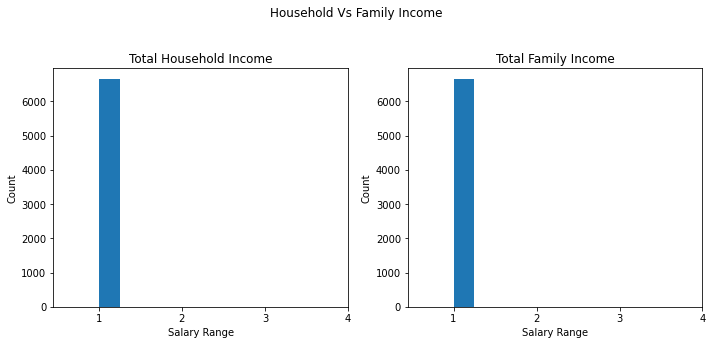

In [89]:
#Plot the income indicators into histograms according to the new catergories that we arranged them in

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data['INDHHIN2'], bins=4)
ax1.set_ylabel("Count")
ax1.set_xlabel("Salary Range")
ax1.set_title("Total Household Income")
ax1.set_xticks([1,2,3,4]) 
ax1.set_xticklabels([1,2,3,4])

ax2.hist(SES_data['INDFMIN2'], bins=4)
ax2.set_ylabel("Count")
ax2.set_xlabel("Salary Range")
ax2.set_title("Total Family Income")
ax2.set_xticks([1,2,3,4]) 
ax2.set_xticklabels([1,2,3,4])

fig.suptitle("Household Vs Family Income")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
SES_data['FSD151'].replace(7.0, np.NaN, inplace=True)
SES_data['FSD151'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data['FSD151'].fillna(round(SES_data['FSD151'].mean()), inplace=True)

SES_data['FSQ165'].replace(7.0, np.NaN, inplace=True)
SES_data['FSQ165'].replace(9.0, np.NaN, inplace=True)
#Round function used to keep integer values only within the Dataframe
SES_data['FSQ165'].fillna(round(SES_data['FSQ165'].mean()), inplace=True)

final_data['FSD151'] = SES_data['FSD151']
final_data['FSQ165'] = SES_data['FSQ165']

In [ ]:
# Features showing benefit

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(SES_data['FSD151'], bins=2)
ax1.set_ylabel("Count")
ax1.set_xlabel("Yes or No")
ax1.set_title("External food received")
ax1.set_xticks([1,2]) 
ax1.set_xticklabels(['Yes','No'])

ax2.hist(SES_data['FSQ165'], bins=2)
ax2.set_ylabel("Count")
ax2.set_xlabel("Yes or No")
ax2.set_title("SNAP benefit received")
ax2.set_xticks([1,2]) 
ax2.set_xticklabels(['Yes','No'])

fig.suptitle("Benefits or external food received")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
# subsetting dataset based on available HbA1c data
mh = ['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']
mental_health = final_data[mh]
final_data.loc[:,'DPQ_score'] = mental_health.drop('SEQN', axis=1).sum(axis=1) # summing up scores

# mental health summary statistic - 4 categories - 0 for normal, 1 for mild, 2 for moderate, 3 for severe
final_data.loc[:,'mental_health_stat'] = pd.cut(final_data['DPQ_score'], [0,4,9,14,27], labels=[0,1,2,3], include_lowest = True)

final_data = final_data.drop(['DPQ010','DPQ020','DPQ030','DPQ050','DPQ070','DPQ080','DPQ090','DPQ100'], axis=1)

In [ ]:
final_data.hist(by='mental_health_stat', column = 'LBXGH',figsize=(10,10), sharex = True)

In [ ]:
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
final_data.loc[:,'WHQ030'] = final_data['WHQ030'].fillna(3).replace(9,3) 
# selecting 'no' for individuals who did not respond to this qn, replacing 'unsure' responses with nil response
final_data.loc[:,'WHQ070'] = final_data['WHQ070'].fillna(2).replace(9,2) 
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value
final_data.loc[:,'DBQ700'] = final_data['DBQ700'].fillna(3).replace(9,3)
# selecting average value for individuals with no inputs, replacing 'unsure' responses with average value\
final_data.loc[:,'HSD010'] = final_data['HSD010'].fillna(3).replace(9,3)

# Subsetting and creating scores for individual self-perception questions
sp = ['SEQN','WHQ030','WHQ070','DBQ700', 'HSD010']
self_perception = final_data[sp]
self_perception.loc[:,'WHQ030_score'] = self_perception['WHQ030'].replace([1,2],0).replace(3,2)
self_perception.loc[:,'WHQ070_score'] = self_perception['WHQ070'].replace(1,0)
self_perception.loc[:,'DBQ700_score'] = self_perception['DBQ700']-1
self_perception.loc[:,'HSD010_score'] = self_perception['HSD010']-1

# Creating summary score for self perception
final_data.loc[:,'self_perception_stat'] = self_perception[['WHQ030_score','WHQ070_score','DBQ700_score','HSD010_score']].sum(axis=1)
final_data.loc[:,'self_perception_stat'] = pd.cut(final_data.loc[:,'DPQ_score'], [0,3,6,9,12], labels=[0,1,2,3], include_lowest = True)

final_data = final_data.drop(['WHQ030','WHQ070','DBQ700','HSD010'], axis=1)

In [ ]:
final_data.hist(by='self_perception_stat', column = 'LBXGH', figsize= (10,10), sharex = True)

In [ ]:
wc = ['SEQN','WHD110','WHD120', 'BMXWT']
weight_change = final_data[wc]

weight_change.loc[:,'WHD110'] = weight_change.loc[:,'WHD110'].replace(7777,np.nan).replace(9999,np.nan) / 2.20462

weight_change.loc[:,'weight_change_10_years'] = weight_change.loc[:,'BMXWT'] - weight_change.loc[:,'WHD110']
final_data.loc[:,'wc_10yr_score'] = pd.cut(weight_change['weight_change_10_years'], [-120,-20,-5,5,20, 120], labels = [0, 1, 2, 3, 4])

final_data = final_data.drop(['WHD110','WHD120','BMXWT'], axis=1)

In [ ]:
final_data.hist(by='wc_10yr_score', column='LBXGH', figsize = (14,14), sharex = True)

In [ ]:
# Defining average blood pressure
final_data.loc[:,'AVGSYBP'] = final_data[['BPXSY1','BPXSY2','BPXSY3']].mean(axis=1)
final_data.loc[:,'AVGDIBP'] = final_data[['BPXDI1','BPXDI2','BPXDI3']].mean(axis=1)

# Dropping base features relating to 1,2,3 measurements of Systolic and Diastolic BP
final_data = final_data.drop(['BPXSY1','BPXSY2','BPXSY3','BPXDI1','BPXDI2','BPXDI3'], axis=1)

In [ ]:
final_data['FSQ165']

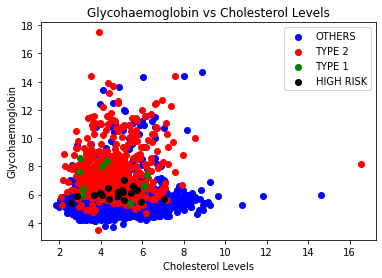

In [150]:
#scatter plot of lab values, 4 groups
X1=dataset['LBDSCHSI'].loc[dataset['DBT']==1]
X2=dataset['LBDSCHSI'].loc[dataset['DBT']==2]
X3=dataset['LBDSCHSI'].loc[dataset['DBT']==3]
X4=dataset['LBDSCHSI'].loc[dataset['DBT']==4]

Y1=dataset['LBXGH'].loc[dataset['DBT']==1]
Y2=dataset['LBXGH'].loc[dataset['DBT']==2]
Y3=dataset['LBXGH'].loc[dataset['DBT']==3]
Y4=dataset['LBXGH'].loc[dataset['DBT']==4]

plt.figure(1)
plt.title('Glycohaemoglobin vs Cholesterol Levels')
plt.ylabel('Glycohaemoglobin')
plt.xlabel('Cholesterol Levels')
plt.scatter(X4,Y4,c='blue')
#plt.figure(2)
plt.scatter(X2,Y2,c='red')
#plt.figure(3)
plt.scatter(X1,Y1,c='green')
#plt.figure(4)
plt.scatter(X3,Y3,c='black')
lgd=[
    'OTHERS',
    'TYPE 2',
    'TYPE 1',
    'HIGH RISK',
]
plt.legend(lgd)
plt.show()

#dont see much differences between these groups since the diabetic grps are taking meds to control these indicators